# Data exploration and checking the UV plane generator

## Imports

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import ehtim as eh
from scipy.ndimage import gaussian_filter

## UV Plane generator function to test

In [56]:
import numpy as np
import random
import math
import torch
from PIL import Image


def uv_generate(output_size, radius=(0.0, 0.1), telescope_num=(6, 8), datapoints=(5, 15), rotation=(60, 120)):
    '''
    A function that returns a UV plane simulation with several parameters
    
    :param output_size: the output width/height of the image in pixels
    :param radius: The range for maximum and minimum randomly generated radii
    :param telescope_num: The range of number of telescopes in the simulation
    :param datapoints: the range of number of datapoints to take for each telescope
    :param rotation: the range of the amount the earth rotates (in degrees)
    :return: 
    '''
    
    # get radii parameters
    earthrad = output_size // 2
    minrad = round(radius[0] * earthrad)
    maxrad = round(radius[1] * earthrad)
    
    # get random value inside provided ranges
    rand_tel_num = random.randint(*telescope_num)
    rand_datapts = random.randint(*datapoints)
    rand_rot = random.randint(*rotation)
    
    # break rotation into discrete datapoints
    delta_theta = rand_rot / rand_datapts

    img_plane_phi = random.random() * 90

    uv_coords = []
    for t in range(rand_tel_num):
        theta = random.random() * 359
        phi = random.random() * 180
        radius = minrad + random.random() * (maxrad - minrad)


        for pt_num in range(rand_datapts):
            # x y z values corresponding to each rotation of the earth for a certain telescope
            x = radius * np.cos(math.radians(theta + pt_num * delta_theta)) * np.sin(math.radians(phi))
            y = radius * np.sin(math.radians(theta + pt_num * delta_theta)) * np.sin(math.radians(phi))
            z = radius * np.cos(math.radians(phi))

            # these same values inside the plane "pi"
            # xpi = x + rsin(phi) - sin(phi)(xsin(phi) + zcos(phi))
            x_pi = x + earthrad * np.sin(math.radians(img_plane_phi)) - np.sin(math.radians(img_plane_phi)) * \
                (x * np.sin(math.radians(img_plane_phi)) + z * np.cos(math.radians(img_plane_phi)))

            # zpi = z + rcos(phi) - cos(phi)(xsin(phi) + zcos(phi))
            z_pi = z + earthrad * np.cos(math.radians(img_plane_phi)) - np.cos(math.radians(img_plane_phi)) * \
                (x * np.sin(math.radians(img_plane_phi)) + z * np.cos(math.radians(img_plane_phi)))

            # the distances are calculated from the line where the plane touches the sphere:
            # v = sqrt((rcos(phi) - zpi))^2 + (rsin(phi) - xpi)^2)
            # v is positive if z value is greater than the "pivot point" which is rcos(phi)
            # u is simply the y term: it is not transformed
            v_term = np.sqrt((earthrad * np.cos(math.radians(img_plane_phi)) - z_pi)**2 +
                             (earthrad * np.sin(math.radians(img_plane_phi)) - x_pi)**2)
            v = v_term if z_pi > earthrad * np.cos(math.radians(img_plane_phi)) else v_term * -1
            u = y

            # every uv term has a corresponding negative, to account for both directions of interferometry:
            neg_u = -u
            neg_v = -v

            # add the radius to make sure array indices are greater than 0
            v += earthrad
            u += earthrad
            neg_u += earthrad
            neg_v += earthrad

            uv_coords.append([u, v])
            uv_coords.append([neg_u, neg_v])

    uv_image = np.zeros(shape=(output_size, output_size)) #.astype(np.uint8)
    uv_coords = np.asarray(uv_coords).astype(np.uint16)

    for uv_coord in uv_coords:
        # append v first as it is the "column" of the image and u is the "row"
        uv_image[uv_coord[1]][uv_coord[0]] += 1

    uv_image /= uv_image.max()

    return uv_image

## Visualize Real Coverage

Opening ./raw_data/M87_data/UVdata/blackhole-18-05.oifits
1 wavelength table with 1 wavelength in total
1 target
1 array with 8 stations
10500 visibility measurements
10500 visibility^2 measurements
5910 closure phase measurements
Loading fits image:  ./raw_data/M87_data/targetImgs/blackhole-18-05.fits


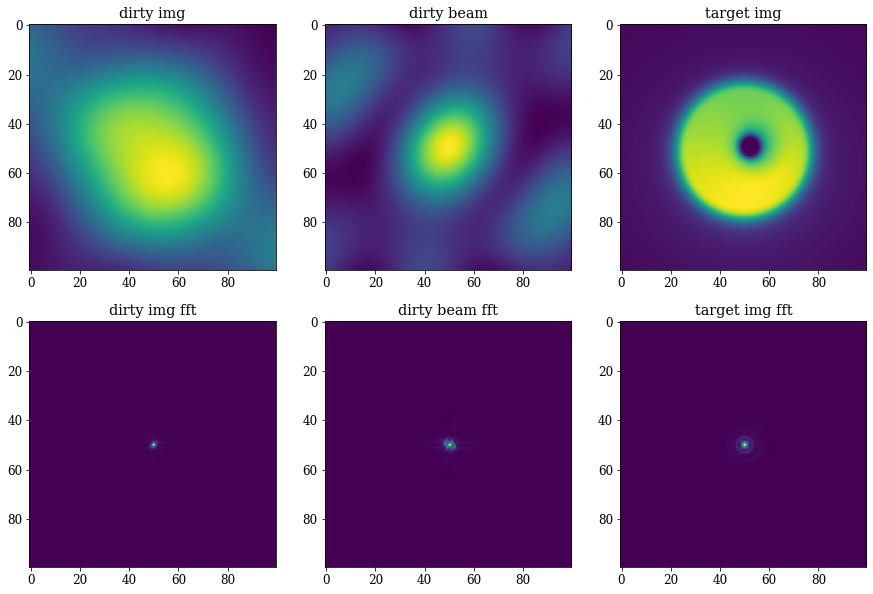

In [57]:
path = './raw_data/M87_data/UVdata/blackhole-18-05.oifits'

# load observation and target
obs = eh.obsdata.load_oifits(path)
target = eh.image.load_fits(path.replace('UVdata', 'targetImgs').replace('oifits', 'fits'))

# get fov and pixels of target (match for observation)
fov = target.fovx() * 1
target = target.imarr()
npix = target.shape[0]

# get beam and dirty image
dbeam = obs.dirtybeam(npix, fov).imarr()
dim = obs.dirtyimage(npix, fov).imarr()

f, axs = plt.subplots(2, 3, figsize=(15, 10))

# image space visualize
axs[0, 0].imshow(dim)
axs[0, 0].set_title('dirty img')
axs[0, 1].imshow(dbeam)
axs[0, 1].set_title('dirty beam')
axs[0, 2].imshow(target)
axs[0, 2].set_title('target img')

# freq space visualize
axs[1, 0].imshow(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(dim)))))
axs[1, 0].set_title('dirty img fft')
axs[1, 1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(dbeam)))))
axs[1, 1].set_title('dirty beam fft')
axs[1, 2].imshow(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(target)))))
axs[1, 2].set_title('target img fft')

plt.show()

## Visualize Generated Coverage

Compared to before, parameters definitely seem to better match the simulated/real visibility plane coverage provided! 

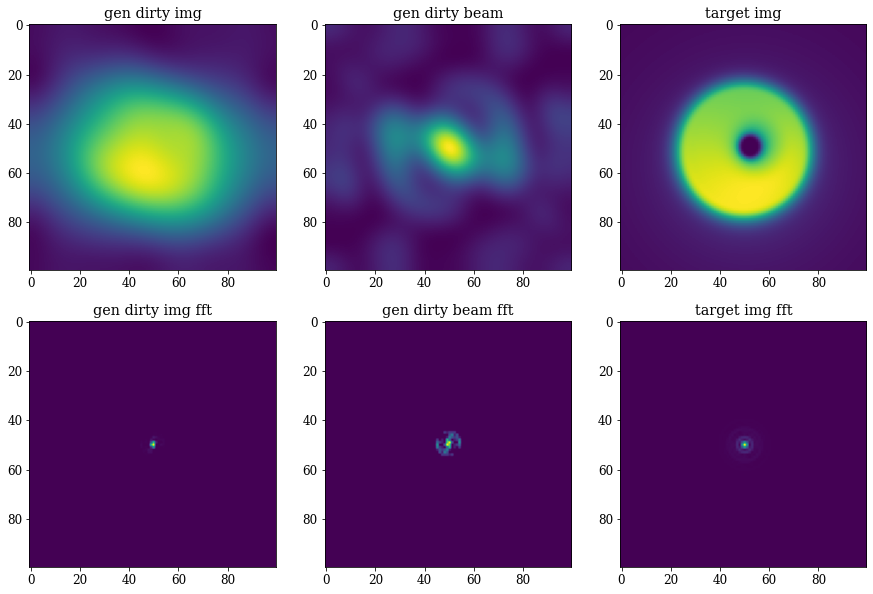

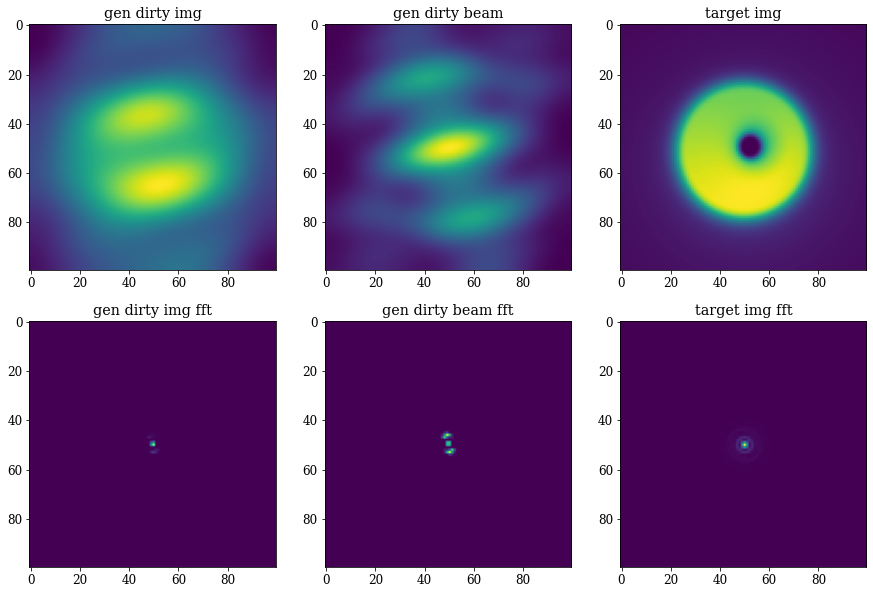

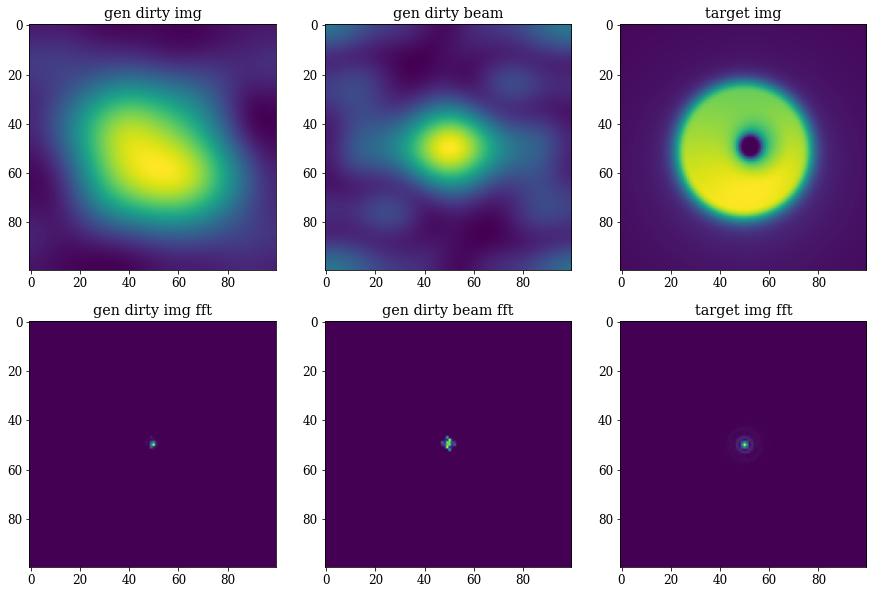

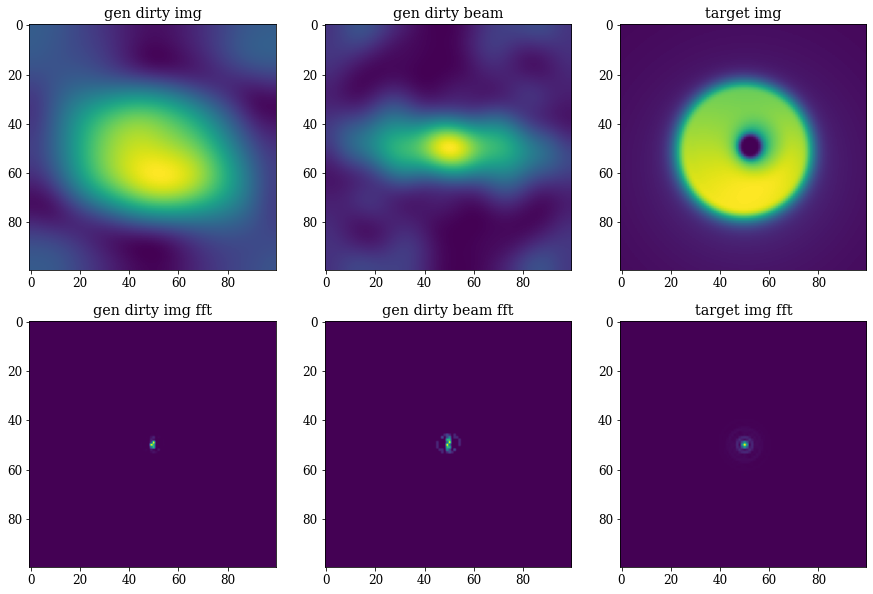

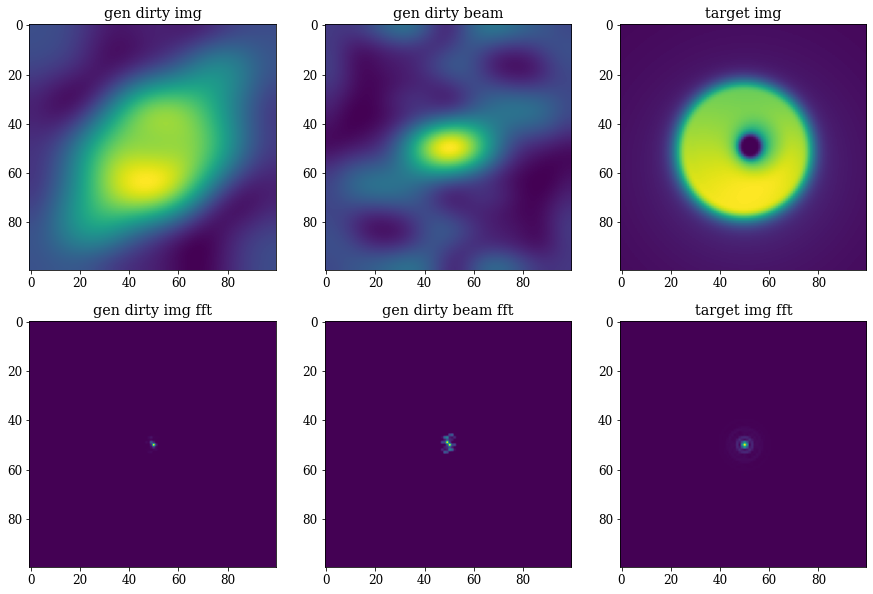

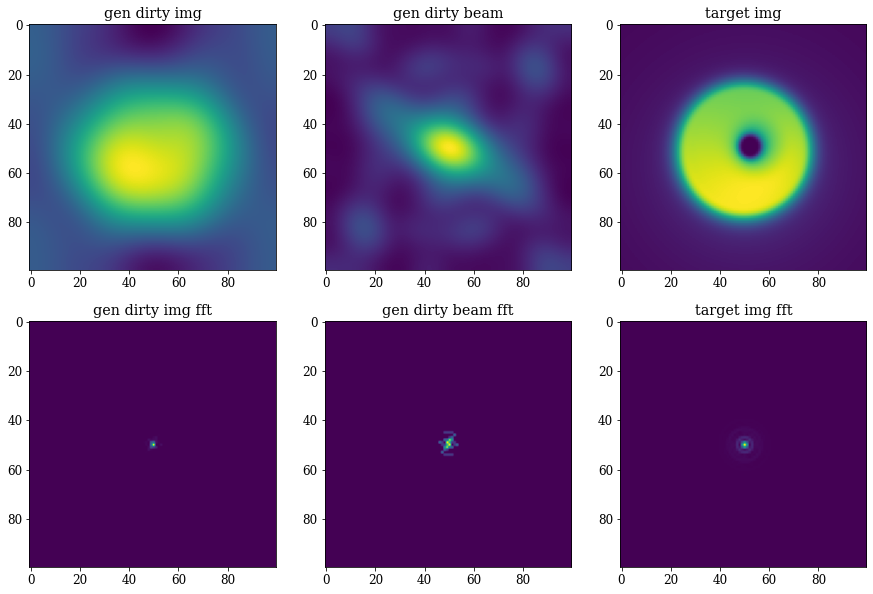

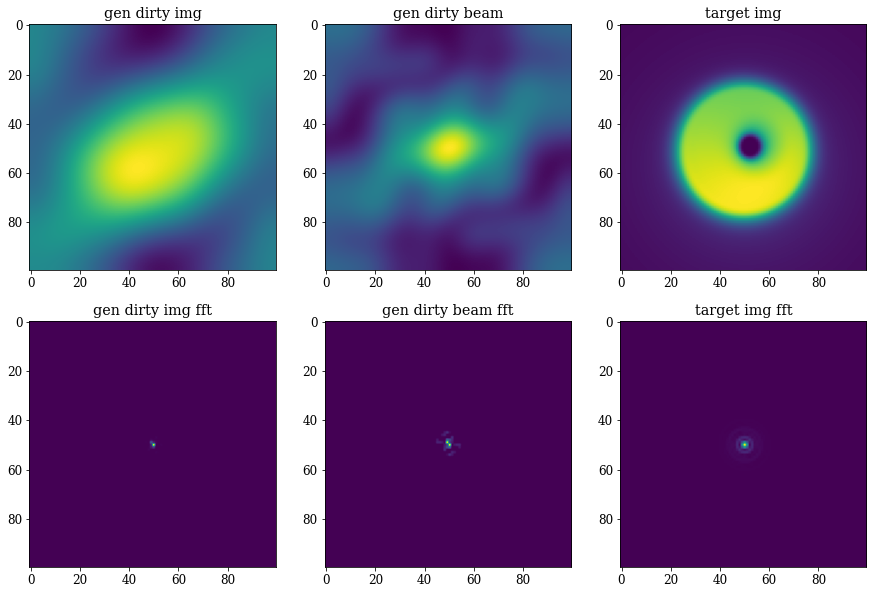

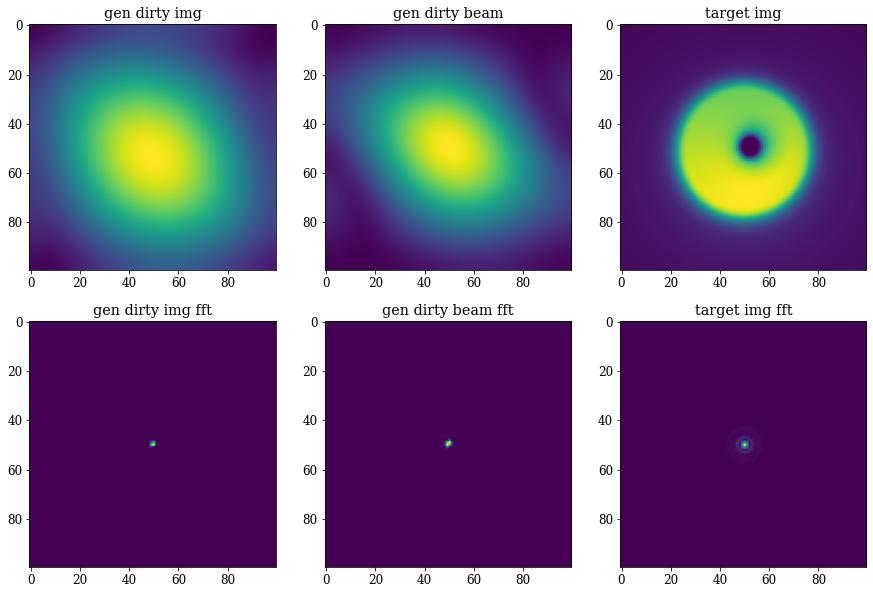

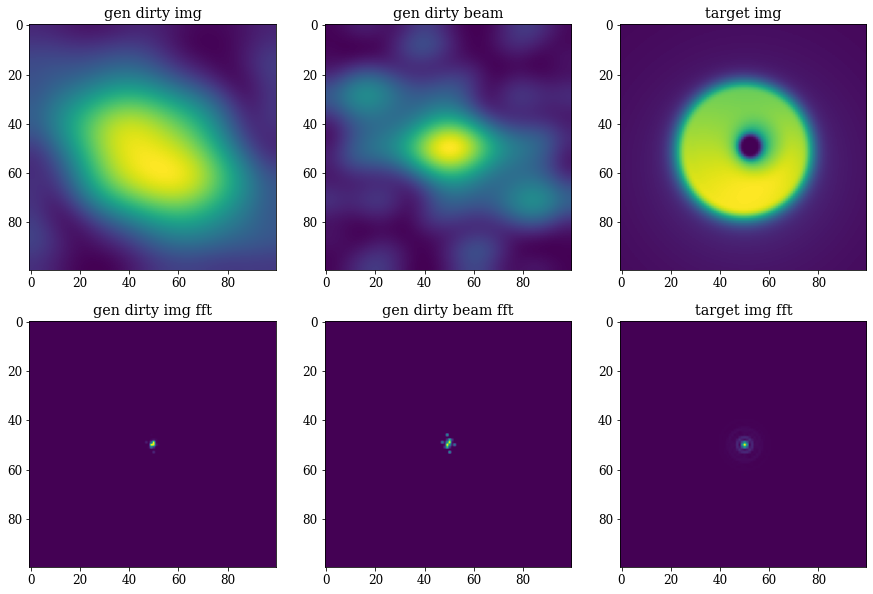

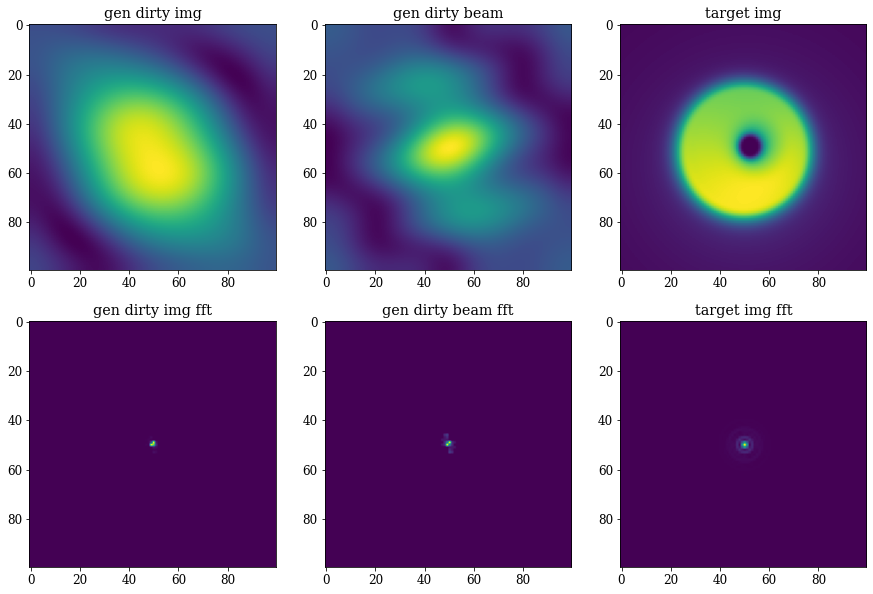

In [59]:
for gen_coverage in range(10):
    
    # generate random UV coverage similar in parameters to actual beams
    gen_coverage = uv_generate(npix)
    
    # gen_coverage is in FREQ SPACE, equv to fft of dirty beam
    # do ifft on gen_coverage to get dirty beam
    gen_dirty_beam = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(gen_coverage))))
    
    # visibilities = fft_gen_dirty_img = fft(target) * coverage
    fft_target = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(target)))
    fft_gen_dirty_img = fft_target * gen_coverage
    gen_dirty_img = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(fft_target * gen_coverage))))
    
    f, axs = plt.subplots(2, 3, figsize=(15, 10))

    # image space visualize, smooth imgs with gaussian filter
    axs[0, 0].imshow(gaussian_filter(gen_dirty_img, sigma=5)) 
    axs[0, 0].set_title('gen dirty img')
    axs[0, 1].imshow(gaussian_filter(gen_dirty_beam, sigma=5))
    axs[0, 1].set_title('gen dirty beam')
    axs[0, 2].imshow(target)
    axs[0, 2].set_title('target img')

    # freq space visualize
    axs[1, 0].imshow(np.abs(fft_gen_dirty_img))
    axs[1, 0].set_title('gen dirty img fft')
    axs[1, 1].imshow(gen_coverage)
    axs[1, 1].set_title('gen dirty beam fft')
    axs[1, 2].imshow(np.abs(fft_target))
    axs[1, 2].set_title('target img fft')
